## 1. Setup

### 1.1 Importar Libs

In [3]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import json
import pickle
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
from joblib import dump, load
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Importar funções dos módulos customizados
from ml_utils import gmean_score, evaluate_model, load_and_prepare_datasets
from search_utils import (plot_search_history, multiple_randomized_search,
                          plot_search_history_from_loaded, 
                          load_search_results, get_best_params_from_saved,
                          save_search_results, save_final_results, DEFAULT_CV_STRATEGY)

# Configurações de plotagem
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")

print("Bibliotecas importadas com sucesso!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"XGBoost: {xgb.__version__}")

Bibliotecas importadas com sucesso!
Pandas: 2.3.2
NumPy: 2.3.3
Scikit-learn: 1.7.2
XGBoost: 3.1.2


### 1.2 Definir Comitê Heterogêneo (Stacking)

In [ ]:
# ======================================================================
# COMITÊ HETEROGÊNEO (STACKING) - IMPLEMENTAÇÃO COM WEAK LEARNERS
# ======================================================================

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier

class HeterogeneousStackingCommittee(BaseEstimator, ClassifierMixin):
    def __init__(self, 
                 # === DECISION TREE - Weak Learner ===
                 dt_max_depth=3,
                 dt_min_samples_split=20,
                 dt_min_samples_leaf=10,
                 dt_criterion='gini',
                 dt_max_features=None,
                 
                 # === MLP - Weak Learner ===
                 mlp_hidden_layers=(50,),
                 mlp_alpha=1.0,
                 mlp_learning_rate_init=0.01,
                 mlp_max_iter=100,
                 mlp_activation='relu',
                 mlp_learning_rate='constant',
                 
                 # === XGBOOST - Weak Learner ===
                 xgb_n_estimators=30,
                 xgb_max_depth=2,
                 xgb_learning_rate=0.05,
                 xgb_subsample=0.5,
                 xgb_colsample_bytree=0.5,
                 xgb_min_child_weight=5,
                 xgb_gamma=0.1,
                 xgb_reg_alpha=1.0,
                 xgb_reg_lambda=1.0,
                 
                 # === META-ESTIMADOR ===
                 meta_C=1.0,
                 meta_max_iter=1000,
                 
                 # === CONFIGURAÇÕES GERAIS ===
                 cv=5,
                 random_state=None):
        """
        Comitê Heterogêneo com Weak Learners Diversos
        
        Estimadores Base (Weak Learners):
        ----------------------------------
        - Decision Tree: Árvore rasa com regras simples
        - MLP: Rede neural shallow com regularização forte
        - XGBoost: Gradient boosting conservador
        
        Meta-Estimador:
        ---------------
        - Logistic Regression: Aprende combinação linear ótima
        
        Estratégia:
        -----------
        - Cada modelo é "fraco" individualmente 
        - Diversidade de paradigmas garante erros não-correlacionados
        - Stacking combina forças e corrige fraquezas
        """
        # Decision Tree
        self.dt_max_depth = dt_max_depth
        self.dt_min_samples_split = dt_min_samples_split
        self.dt_min_samples_leaf = dt_min_samples_leaf
        self.dt_criterion = dt_criterion
        self.dt_max_features = dt_max_features
        
        # MLP
        self.mlp_hidden_layers = mlp_hidden_layers
        self.mlp_alpha = mlp_alpha
        self.mlp_learning_rate_init = mlp_learning_rate_init
        self.mlp_max_iter = mlp_max_iter
        self.mlp_activation = mlp_activation
        self.mlp_learning_rate = mlp_learning_rate
        
        # XGBoost
        self.xgb_n_estimators = xgb_n_estimators
        self.xgb_max_depth = xgb_max_depth
        self.xgb_learning_rate = xgb_learning_rate
        self.xgb_subsample = xgb_subsample
        self.xgb_colsample_bytree = xgb_colsample_bytree
        self.xgb_min_child_weight = xgb_min_child_weight
        self.xgb_gamma = xgb_gamma
        self.xgb_reg_alpha = xgb_reg_alpha
        self.xgb_reg_lambda = xgb_reg_lambda
        
        # Meta-estimador
        self.meta_C = meta_C
        self.meta_max_iter = meta_max_iter
        
        # Geral
        self.cv = cv
        self.random_state = random_state
        
    def fit(self, X, y):
        # Criar weak estimators
        base_estimators = [
            ('weak_dt', DecisionTreeClassifier(
                max_depth=self.dt_max_depth,
                min_samples_split=self.dt_min_samples_split,
                min_samples_leaf=self.dt_min_samples_leaf,
                criterion=self.dt_criterion,
                max_features=self.dt_max_features,
                random_state=self.random_state
            )),
            ('weak_mlp', MLPClassifier(
                hidden_layer_sizes=self.mlp_hidden_layers,
                alpha=self.mlp_alpha,
                learning_rate_init=self.mlp_learning_rate_init,
                learning_rate=self.mlp_learning_rate,
                max_iter=self.mlp_max_iter,
                activation=self.mlp_activation,
                solver='lbfgs',
                early_stopping=True,
                validation_fraction=0.2,
                random_state=self.random_state,
                verbose=False
            )),
            ('weak_xgb', xgb.XGBClassifier(
                n_estimators=self.xgb_n_estimators,
                max_depth=self.xgb_max_depth,
                learning_rate=self.xgb_learning_rate,
                subsample=self.xgb_subsample,
                colsample_bytree=self.xgb_colsample_bytree,
                min_child_weight=self.xgb_min_child_weight,
                gamma=self.xgb_gamma,
                reg_alpha=self.xgb_reg_alpha,
                reg_lambda=self.xgb_reg_lambda,
                objective='binary:logistic',
                eval_metric='logloss',
                random_state=self.random_state,
                verbosity=0
            ))
        ]
        
        # Meta-estimador
        meta_estimator = LogisticRegression(
            C=self.meta_C,
            max_iter=self.meta_max_iter,
            random_state=self.random_state
        )
        
        # Criar Stacking
        self.stacking_classifier = StackingClassifier(
            estimators=base_estimators,
            final_estimator=meta_estimator,
            cv=self.cv,
            stack_method='predict_proba',
            n_jobs=1
        )
        
        # Treinar
        self.stacking_classifier.fit(X, y)
        self.classes_ = self.stacking_classifier.classes_
        
        return self
    
    def predict(self, X):
        return self.stacking_classifier.predict(X)
    
    def predict_proba(self, X):
        return self.stacking_classifier.predict_proba(X)
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))



### 1.3 Configuração do Modelo

In [ ]:
# Configuração do modelo e hiperparâmetros
MODEL_NAME = "Stacking"
MODEL_CLASS = HeterogeneousStackingCommittee
RANDOM_STATE_MODEL = 42
RANDOM_STATE_SAMPLE = 10

# Configuração da busca de hiperparâmetros
N_SEARCHES = 20
N_ITER_PER_SEARCH = 3
SAMPLE_SIZE = 0.05  # % of training data for hyperparameter search

# Pastas para salvamento
SEARCHES_FOLDER = 'searches'
RESULTS_FOLDER = 'results'
MODELS_FOLDER = 'models'

print(f"Modelo configurado: {MODEL_NAME}")
print(f"Buscas: {N_SEARCHES} x {N_ITER_PER_SEARCH} iterações")

Modelo configurado: Stacking
Buscas: 20 x 10 iterações


## 2. Carregamento e Preparação dos Dados

In [7]:
# Carregamento e preparação inicial dos dados
print("=== CARREGAMENTO DOS DATASETS ===")

# Carregar e preparar datasets usando função do módulo
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, train_data, test_data, scaler = load_and_prepare_datasets()

print(f"Dataset de treino: {train_data.shape}")
print(f"Dataset de teste: {test_data.shape}")
print(f"Features: {X_train_scaled.shape[1]}")

print("\nDistribuição das classes:")
print("Treino:", y_train.value_counts().to_dict())
print("Teste:", y_test.value_counts().to_dict())

print("\nPrimeiras linhas do dataset de treino:")

=== CARREGAMENTO DOS DATASETS ===
Dataset de treino: (72795, 17)
Dataset de teste: (8180, 17)
Features: 16

Distribuição das classes:
Treino: {0.0: 54175, 1.0: 18620}
Teste: {0.0: 5894, 1.0: 2286}

Primeiras linhas do dataset de treino:


In [10]:
train_data.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,WBC,Platelets,Gender,Unit1,Unit2,HospAdmTime,ICULOS,Critical_Risk_Window,Time_Category,SepsisLabel
0,8,-1.109794,-0.460180,-0.936182,2.873365,3.044201,2.159974,-0.073601,-0.277186,-1.393580,0.450716,1.0,1.0,0.0,-12.06,9.0,0,0,0.0
1,47,0.569971,-2.437770,0.173477,0.393960,0.650783,0.430943,-0.997324,0.309171,0.245616,-0.275108,1.0,1.0,0.0,-0.05,48.0,0,1,0.0
2,6,0.150030,0.978068,0.016114,-0.983487,-0.553850,-0.198683,-0.073601,-0.310739,0.121368,-0.191266,1.0,1.0,0.0,-0.02,7.0,0,0,0.0
3,39,-0.269912,0.258944,0.289355,0.853109,0.405094,-0.115460,0.752015,0.298591,-0.003965,-3.152920,0.0,0.0,1.0,-75.85,43.0,0,1,0.0
4,127,0.569971,-0.460180,0.007012,0.761279,1.834255,1.055050,-0.520987,0.702140,-0.180545,0.030433,0.0,0.0,1.0,-0.03,128.0,1,2,0.0


## 3. Sampling para Busca de Hiperparâmetros

In [8]:
# ======================================================================
# SAMPLING ESTRATIFICADO PARA BUSCA DE HIPERPARÂMETROS
# ======================================================================

print("=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===")

# Amostra estratificada do dataset de treino
_, X_sample, _, y_sample = train_test_split(
    X_train_scaled, y_train, 
    test_size=SAMPLE_SIZE,  
    stratify=y_train,
    random_state=RANDOM_STATE_SAMPLE
)

print(f"Dataset original de treino: {X_train_scaled.shape[0]:,} amostras")
print(f"Amostra para busca de hiperparâmetros: {X_sample.shape[0]:,} amostras")
print(f"Redução: {(1 - X_sample.shape[0]/X_train_scaled.shape[0])*100:.1f}%")

print("\nDistribuição das classes na amostra:")
print("Amostra:", pd.Series(y_sample).value_counts().to_dict())
print("Original:", y_train.value_counts().to_dict())

=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===
Dataset original de treino: 72,795 amostras
Amostra para busca de hiperparâmetros: 728 amostras
Redução: 99.0%

Distribuição das classes na amostra:
Amostra: {0.0: 542, 1.0: 186}
Original: {0.0: 54175, 1.0: 18620}


## 4. Definir Estratégia de Validação Cruzada

In [9]:
# Usar estratégia de CV padrão dos módulos
cv_strategy = DEFAULT_CV_STRATEGY
print(f"Estratégia de CV: {cv_strategy}")

Estratégia de CV: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


## 5. Stacking - Busca de Hiperparâmetros


### 5.1 Definir Espaço de Hiperparâmetros


In [16]:
# ======================================================================
# 4.1 BUSCA DE HIPERPARAMETROS - WEAK LEARNERS
# ======================================================================

print(f"=== BUSCA DE HIPERPARÂMETROS - {MODEL_NAME} ===")

# Definição do Espaço de Hiperparâmetros para Weak Learners
# Cada range é uma VERSÃO MENOR do espaço original do modelo individual

param_distributions = {
    # === DECISION TREE - Weak (comparar com notebook 3) ===
    # Original: max_depth(3-50), min_samples_split(2-40), min_samples_leaf(1-50)
    'dt_max_depth': randint(1, 10),              # Weak: 1-4 (vs 3-50)
    'dt_min_samples_split': randint(10, 75),    # Weak: 10-29 (vs 2-40)
    'dt_min_samples_leaf': randint(15, 85),     # Weak: 15-49 (vs 1-50)
    
    # === MLP - Weak (comparar com notebook 8) ===
    # Original: 8 arquiteturas (até 4 camadas), alpha(0.01-0.1), LR(0.001-0.1), iter(200-600)
    'mlp_hidden_layers': [(25,), (50,), (100,), (150,), (200,), # Weak: 1-3 camadas (vs 3-4)
                          (50, 25), (100, 50), (100, 100), (100, 25),
                          (50, 50), (25, 200), (25, 25), (50, 200),
                          (150, 50), (100, 150), (150, 25), (50, 100),
                          (25, 25, 25), (50, 25, 25), (25, 50, 25), (25, 25, 50)], 
    'mlp_alpha': uniform(0.05, 0.15),             # Weak: 0.05-0.20 (vs 0.01-0.1)
    'mlp_learning_rate_init': uniform(0.01, 0.1), # Weak: 0.001-0.051 (vs 0.001-0.1)
    'mlp_max_iter': randint(50, 200),               # Weak: 50-150 (vs 200-600)
    'mlp_activation': ['relu', 'tanh'],           # Subset de ['relu', 'tanh', 'logistic']
    
    # === XGBOOST - Weak (comparar com notebook 6) ===
    # Original: n_est(140-381), depth(3-11), LR(0.5-1.5), subsample(0.6-0.9), reg(0.5-1.5)
    'xgb_n_estimators': randint(20, 120),        # Weak: 20-59 (vs 140-381)
    'xgb_max_depth': randint(1, 4),             # Weak: 1-3 (vs 3-11)
    'xgb_learning_rate': uniform(0.1, 1),       # Weak: 0.01-0.16 (vs 0.5-1.5)
    'xgb_subsample': uniform(0.3, 0.3),         # Weak: 0.3-0.6 (vs 0.6-0.9)
    'xgb_colsample_bytree': uniform(0.3, 0.3),  # Weak: 0.3-0.6 (vs 0.2-0.7)
    'xgb_min_child_weight': randint(5, 20),     # Weak: 5-14 (vs 1-20) 
    'xgb_gamma': uniform(0.1, 0.3),             # Weak: 0.1-0.4 (vs 0.1-0.5)
    'xgb_reg_alpha': uniform(0.5, 0.5),         # Weak: 0.5-1.0 (vs 0.5-2.0) 
    'xgb_reg_lambda': uniform(0.5, 0.5),        # Weak: 0.5-1.0 (vs 0.5-2.0)
    
    # === META-ESTIMADOR ===
    'meta_C': uniform(5, 50),                 # LogisticRegression
    'meta_max_iter': randint(1000, 3000),
}



=== BUSCA DE HIPERPARÂMETROS - Stacking ===


### 5.2 Executar Busca de Hiperparâmetros

In [17]:
# ======================================================================
# BUSCA DE HIPERPARAMETROS
# ======================================================================

print(f"=== BUSCA DE HIPERPARÂMETROS - {MODEL_NAME} ===")
print(f"Iniciando busca de hiperparâmetros para {MODEL_NAME}...")
print(f"Executando {N_SEARCHES} buscas com {N_ITER_PER_SEARCH} iterações cada...")
print(f"Usando amostra de {X_sample.shape[0]:,} exemplos\n")

# Múltiplas execuções do RandomizedSearchCV
search, all_searches, best_params = multiple_randomized_search(
    estimator=HeterogeneousStackingCommittee(random_state=RANDOM_STATE_MODEL, cv=3),
    param_distributions=param_distributions,
    X=X_sample,
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=N_SEARCHES,
    n_iter_per_search=N_ITER_PER_SEARCH,
    scoring='f1',
    random_state=None,
    n_jobs=1
)

# Exibir os melhores resultados
print(f"\n--- RESULTADOS {MODEL_NAME} ---")
print("Melhores hiperparâmetros encontrados:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"\nMelhor F1-Score (CV): {search.best_score_:.4f}")
print(f"Desvio padrão: {search.cv_results_['std_test_score'][search.best_index_]:.4f}")

=== BUSCA DE HIPERPARÂMETROS - Stacking ===
Iniciando busca de hiperparâmetros para Stacking...
Executando 20 buscas com 10 iterações cada...
Usando amostra de 728 exemplos

Executando 20 buscas com 10 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.5577
Melhor configuração desta busca: {'dt_max_depth': 1, 'dt_min_samples_leaf': 78, 'dt_min_samples_split': 25, 'meta_C': np.float64(38.066807562093096), 'meta_max_iter': 2329, 'mlp_activation': 'relu', 'mlp_alpha': np.float64(0.1377914821636433), 'mlp_hidden_layers': (50, 200), 'mlp_learning_rate_init': np.float64(0.0929689836144492), 'mlp_max_iter': 95, 'xgb_colsample_bytree': np.float64(0.5439246468711522), 'xgb_gamma': np.float64(0.367622854113291), 'xgb_learning_rate': np.float64(0.6044989526347551), 'xgb_max_depth': 1, 'xgb_min_child_weight': 12, 'xgb_n_estimators': 43, 'xgb_reg_alpha': np.float64(0.9985864683859035), 'xgb_reg_lambda': np.float64(0.9526589738260436), 'xgb_subsample': np.float64(0.41633979871595167)}
Melh

### 5.3 Visualizar Histórico da Busca

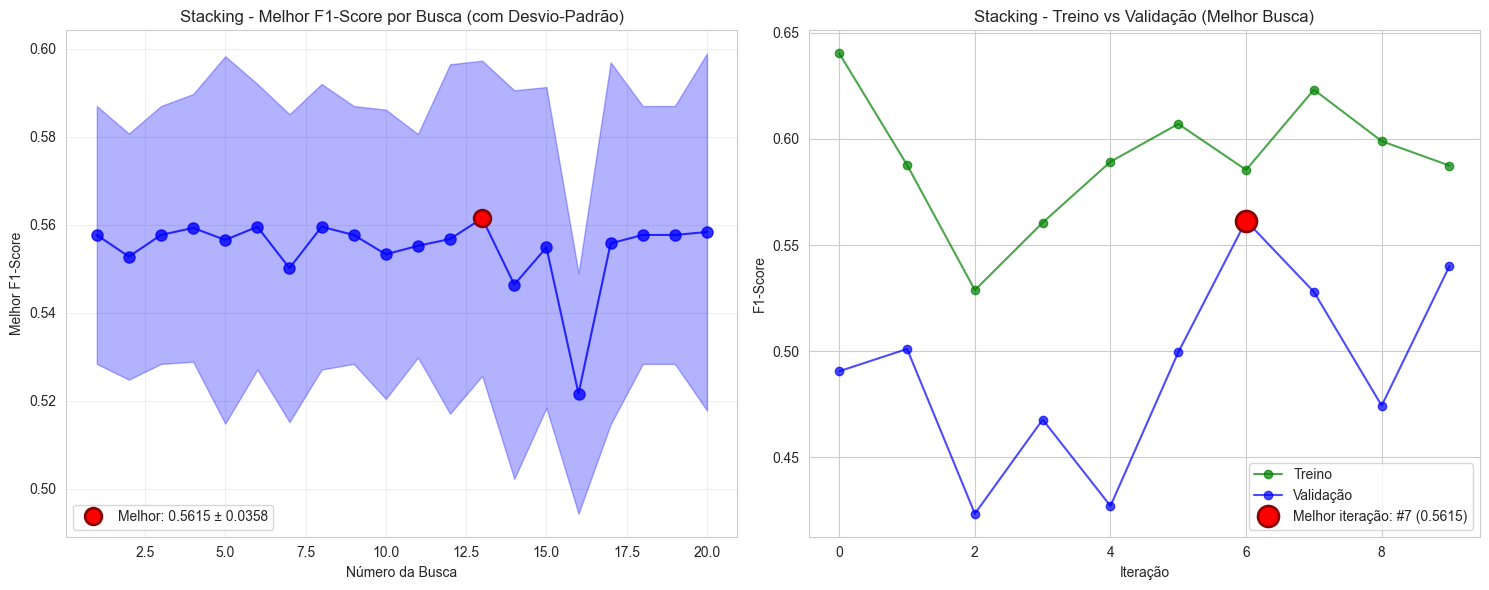

In [18]:
# Registro de Desempenho - plotar evolução da busca
plot_search_history(all_searches, search, MODEL_NAME)

In [19]:
# ======================================================================
# ANÁLISE DAS MELHORES CONFIGURAÇÕES ENCONTRADAS
# ======================================================================

print(f"=== MELHORES CONFIGURAÇÕES ENCONTRADAS POR BUSCA - {MODEL_NAME} ===")

# Extrair os melhores resultados de cada busca
best_configs = []

for i, search_result in enumerate(all_searches):
    config = {
        'Busca': i + 1,
        'F1_Score': search_result['best_score'],
        **search_result['best_params']
    }
    best_configs.append(config)

# Criar DataFrame e exibir top configs
results_df = pd.DataFrame(best_configs)
results_df = results_df.sort_values('F1_Score', ascending=False).round(4)

print(f"\nTop configurações (de {len(results_df)} buscas):")
print(results_df.to_string(index=False))

print(f"\nEstatísticas dos F1-Scores encontrados:")
print(f"  Média: {results_df['F1_Score'].mean():.4f}")
print(f"  Mediana: {results_df['F1_Score'].median():.4f}")
print(f"  Desvio padrão: {results_df['F1_Score'].std():.4f}")
print(f"  Min: {results_df['F1_Score'].min():.4f}")
print(f"  Max: {results_df['F1_Score'].max():.4f}")

=== MELHORES CONFIGURAÇÕES ENCONTRADAS POR BUSCA - Stacking ===

Top configurações (de 20 buscas):
 Busca  F1_Score  dt_max_depth  dt_min_samples_leaf  dt_min_samples_split  meta_C  meta_max_iter mlp_activation  mlp_alpha mlp_hidden_layers  mlp_learning_rate_init  mlp_max_iter  xgb_colsample_bytree  xgb_gamma  xgb_learning_rate  xgb_max_depth  xgb_min_child_weight  xgb_n_estimators  xgb_reg_alpha  xgb_reg_lambda  xgb_subsample
    13    0.5615             1                   50                    39  8.7539           1628           tanh     0.0602            (200,)                  0.0101           185                0.4920     0.2538             0.4515              1                    15                90         0.9199          0.5959         0.5094
     6    0.5596             8                   81                    50 23.2570           2695           relu     0.1255         (150, 50)                  0.0529           195                0.5853     0.3122             0.9702       

## 6. Salvar Resultados de Busca

In [15]:

search_df = save_search_results(
    model_name=MODEL_NAME,
    model_search=search,
    model_all_searches=all_searches,
    n_searches=N_SEARCHES,
    n_iter_per_search=N_ITER_PER_SEARCH,
    scoring='f1',
    cv_folds=cv_strategy.get_n_splits(),
    top_params_columns=param_distributions.keys(),
    searches_folder=SEARCHES_FOLDER
)

=== SALVANDO RESULTADOS DA BUSCA - STACKING ===
  ✅ Todos os Resultados salvos: searches\stacking_all_searches.csv
  Total de configurações testadas: 200
  ✅ Resumo salvo: searches\stacking_search_summary.json

--- ESTATÍSTICAS DA BUSCA STACKING ---
Melhor F1-Score: 0.5632
Desvio padrão do melhor: 0.0341
F1-Score médio geral: 0.4905
F1-Score mínimo: 0.3480
F1-Score máximo: 0.5632


### 6.2 Carregar Resultado de Busca (Opcional)

In [ ]:
loaded_results = load_search_results(MODEL_NAME)

In [ ]:
# Plotar a história da busca a partir dos resultados carregados
plot_search_history_from_loaded(loaded_results, MODEL_NAME)

### 6.3 Definir Melhores Params e CV score

In [20]:
# Definir Melhores Parâmetros para Uso Posterior
if 'loaded_results' in locals():
    best_params = get_best_params_from_saved(MODEL_NAME)
    best_score = loaded_results['summary']['best_overall_score']
    print(f"✅ Usando parâmetros carregados: {best_params}")
    print(f"✅ Melhor F1-Score carregado: {best_score:.4f}")
else:
    best_params = search.best_params_
    best_score = search.best_score_
    print(f"✅ Usando parâmetros da busca atual: {best_params}")
    print(f"✅ Melhor F1-Score da busca atual: {best_score:.4f}")

✅ Usando parâmetros da busca atual: {'dt_max_depth': 1, 'dt_min_samples_leaf': 50, 'dt_min_samples_split': 39, 'meta_C': np.float64(8.753900921309157), 'meta_max_iter': 1628, 'mlp_activation': 'tanh', 'mlp_alpha': np.float64(0.06022084078489395), 'mlp_hidden_layers': (200,), 'mlp_learning_rate_init': np.float64(0.010090506377044785), 'mlp_max_iter': 185, 'xgb_colsample_bytree': np.float64(0.4920113653166526), 'xgb_gamma': np.float64(0.25375356719974457), 'xgb_learning_rate': np.float64(0.4515228689436931), 'xgb_max_depth': 1, 'xgb_min_child_weight': 15, 'xgb_n_estimators': 90, 'xgb_reg_alpha': np.float64(0.9198982270574463), 'xgb_reg_lambda': np.float64(0.5959228738937421), 'xgb_subsample': np.float64(0.5094116233084305)}
✅ Melhor F1-Score da busca atual: 0.5615


## 7. Treinar Modelo Final e Salvar

In [27]:
# Treinamento Final com melhores hiperparâmetros

best_model = HeterogeneousStackingCommittee(**best_params)
best_model.fit(X_train_scaled, y_train)
print(f"\nModelo final {MODEL_NAME} treinado com dataset completo: {best_model}")


Modelo final Stacking treinado com dataset completo: HeterogeneousStackingCommittee(dt_max_depth=1, dt_min_samples_leaf=50,
                               dt_min_samples_split=39,
                               meta_C=np.float64(8.753900921309157),
                               meta_max_iter=1628, mlp_activation='tanh',
                               mlp_alpha=np.float64(0.06022084078489395),
                               mlp_hidden_layers=(200,),
                               mlp_learning_rate_init=np.float64(0.010090506377044785),
                               mlp_max_iter=185,
                               xgb_colsample_bytree=np.float64(0.4920113653166526),
                               xgb_gamma=np.float64(0.25375356719974457),
                               xgb_learning_rate=np.float64(0.4515228689436931),
                               xgb_max_depth=1, xgb_min_child_weight=15,
                               xgb_n_estimators=90,
                               xgb_reg_alpha

In [28]:

# Save the trained model immediately after training
os.makedirs(MODELS_FOLDER, exist_ok=True)

model_path = os.path.join(MODELS_FOLDER, f'{MODEL_NAME.lower().replace(" ", "_")}_model.joblib')
dump(best_model, model_path)
print(f"✅ Model saved to: {model_path}")

✅ Model saved to: models\stacking_model.joblib


## 8. Avaliação Final e Salvamento dos Resultados

In [ ]:
# Carregar modelo (Opcional)
loaded_model = load(os.path.join(MODELS_FOLDER, f'{MODEL_NAME.lower().replace(" ", "_")}_model.joblib'))

In [29]:
print(f"=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - {MODEL_NAME} ===")

# Criar pastas se não existirem
os.makedirs(RESULTS_FOLDER, exist_ok=True)

# Avaliação completa do modelo
print("\nAvaliando performance do modelo...")

if 'loaded_model' in locals():
    model = loaded_model
else:
    model = best_model

# Usar datasets completos para avaliação final
X_train_eval = X_train_scaled
y_train_eval = y_train
X_test_eval = X_test_scaled
y_test_eval = y_test

# Avaliar modelo usando função do módulo
train_metrics, test_metrics, y_test_pred = evaluate_model(
    best_model, X_train_eval, X_test_eval, y_train_eval, y_test_eval, MODEL_NAME
)

=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - Stacking ===

Avaliando performance do modelo...


### 8.1 Classification Report

In [30]:
print(classification_report(y_test_eval, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87      5894
         1.0       0.70      0.46      0.56      2286

    accuracy                           0.79      8180
   macro avg       0.76      0.69      0.71      8180
weighted avg       0.78      0.79      0.78      8180



### 8.2 Visualize Confusion Matrix

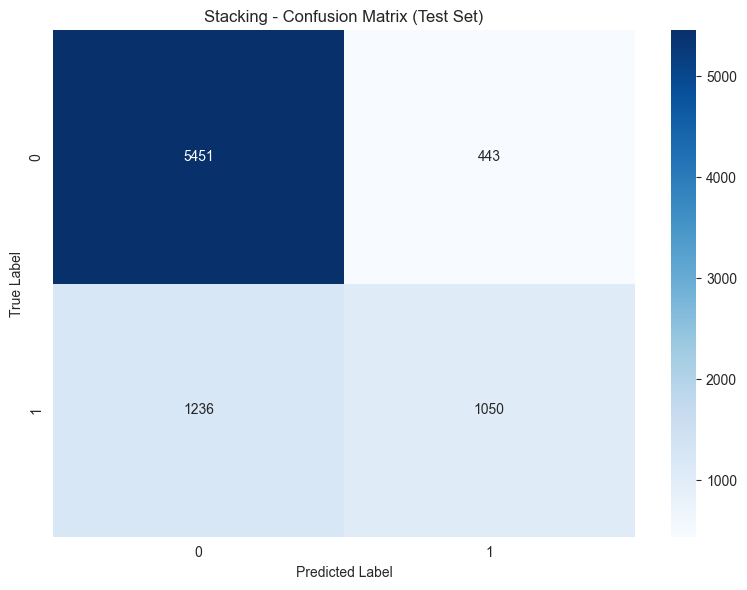

In [31]:
# Plot confusion matrix
cm = confusion_matrix(y_test_eval, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'{MODEL_NAME} - Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 8.3 Save Final Results

In [32]:
# Salvar resultados finais usando função do módulo
model_final_results = save_final_results(
    model_name=MODEL_NAME,
    best_params=best_params,
    best_score=best_score,
    train_metrics=train_metrics,
    test_metrics=test_metrics,
    y_pred=y_test_pred,
    y_test=y_test_eval,
    X_train_scaled=X_train_eval,
    X_test_scaled=X_test_eval,
    results_folder=RESULTS_FOLDER
)

# Mostrar resumo final
print(f"\n--- RESUMO FINAL {MODEL_NAME} ---")
print(f"F1-Score CV: {model_final_results['best_cv_score']:.4f}")
print(f"F1-Score Teste: {test_metrics['f1']:.4f}")
print(f"Acurácia Teste: {test_metrics['accuracy']:.4f}")
print(f"Precisão Teste: {test_metrics['precision']:.4f}")
print(f"Recall Teste: {test_metrics['recall']:.4f}")
print(f"G-Mean Teste: {test_metrics['gmean']:.4f}")
if test_metrics.get('auc_roc'):
    print(f"AUC-ROC Teste: {test_metrics['auc_roc']:.4f}")

print(f"\nHistórico de busca salvo em: {SEARCHES_FOLDER}/")
print(f"Modelo salvo em: {MODELS_FOLDER}/")
print(f"Resultados salvos em: {RESULTS_FOLDER}/")
print(f"\nAvaliação do {MODEL_NAME} concluída com sucesso!")

✅ Resultados Stacking salvos em: results\stacking_results.json

--- RESUMO FINAL Stacking ---
F1-Score CV: 0.5615
F1-Score Teste: 0.5557
Acurácia Teste: 0.7947
Precisão Teste: 0.7033
Recall Teste: 0.4593
G-Mean Teste: 0.6518
AUC-ROC Teste: 0.8253

Histórico de busca salvo em: searches/
Modelo salvo em: models/
Resultados salvos em: results/

Avaliação do Stacking concluída com sucesso!
